LAST content of Victor's-Block in DataPipeline.ipynb (30.10.24)

In [ ]:
# LAST content of Victor-Block in DataPipeline.ipynb (30.10.24)
#
# before spliting DataPipeline -> PreProcessing / Models

# used functions from Utils_CO2 are copied here for stand-alone usage

import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def load_data_gdrive(file_name):
    """
    Ensures Google Drive is mounted, searches for a file by name across the
    entire Google Drive, and loads a parquet or csv file if found.

    Parameters:
    file_name (str): The name of the file to load.

    Returns:
    pd.DataFrame: The loaded data as a pandas DataFrame, or None if the file
    is not found.
    """
    # Function to check and mount Google Drive if not already mounted
    def check_and_mount_drive():
        """Checks if Google Drive is mounted in Colab, and mounts it if not."""
        drive_mount_path = '/content/drive'
        if not os.path.ismount(drive_mount_path):
            print("Mounting Google Drive...")
            # Import inside the condition when it's determined that mounting is needed
            from google.colab import drive
            drive.mount(drive_mount_path)
        else:
            print("Google Drive is already mounted.")

    # Function to search for the file in Google Drive
    def find_file_in_drive(file_name, start_path='/content/drive/My Drive'):
        """Search for a file by name in Google Drive starting from a specified path."""
        for dirpath, dirnames, filenames in os.walk(start_path):
            if file_name in filenames:
                return os.path.join(dirpath, file_name)
        return None

    # Check and mount Google Drive if not already mounted
    check_and_mount_drive()

    # Find the file in Google Drive
    file_path = find_file_in_drive(file_name)
    if not file_path:
        print("File not found.")
        return None

    # Check file extension and load accordingly
    if file_name.endswith('.parquet'):
        print(f"Loading parquet file: {file_path}")
        table = pq.read_table(file_path)
        df = table.to_pandas()  # Convert to pandas DataFrame
    elif file_name.endswith('.csv'):
        print(f"Loading CSV file: {file_path}")
        df = pd.read_csv(file_path)  # Read CSV into pandas DataFrame
    else:
        raise ValueError("Unsupported file format. Please provide a parquet or csv file.")

    return df

# Regression model (Victor)

In [ ]:
# Adapt models to new min_baseline_model(s)

In [ ]:
# -> Loading the data frame [ minimal_x ]

file_name = "minimal_without_fuel_consumption_tn20_mcp00.10.parquet"
df = load_data_gdrive(file_name)

# *
# data-source = /content/drive/MyDrive/CO2/EU_all_current_shared_corrected.parquet
# + Andrea's/Tillman's preprocessing pipeline
#
# Filtering (awareness):
#  - Countries: DE, FR, IT (only as sample, being this countries with the top count ones)
#  - Years: 2019-2023
#           (2023 not present due to NaN handling: At1, At2, W were not reported in 2023)
#  - only internal combustion, non electric, non hybrid
#  - due to one hot encoding with drop-first, top-count label of cat. var. excluded (not present)
# ->
# 3.731.625 rows, 1.601.185 duplicates
# 0% NaNs over all the columns
# categorial vars, already one-hot-encoded (with drop first!)

Mounting Google Drive...
Mounted at /content/drive
Loading parquet file: /content/drive/My Drive/CO2/minimal_without_fuel_consumption_tn20_mcp00.10.parquet


In [ ]:
# -> Inspect the data frame
# df.info()

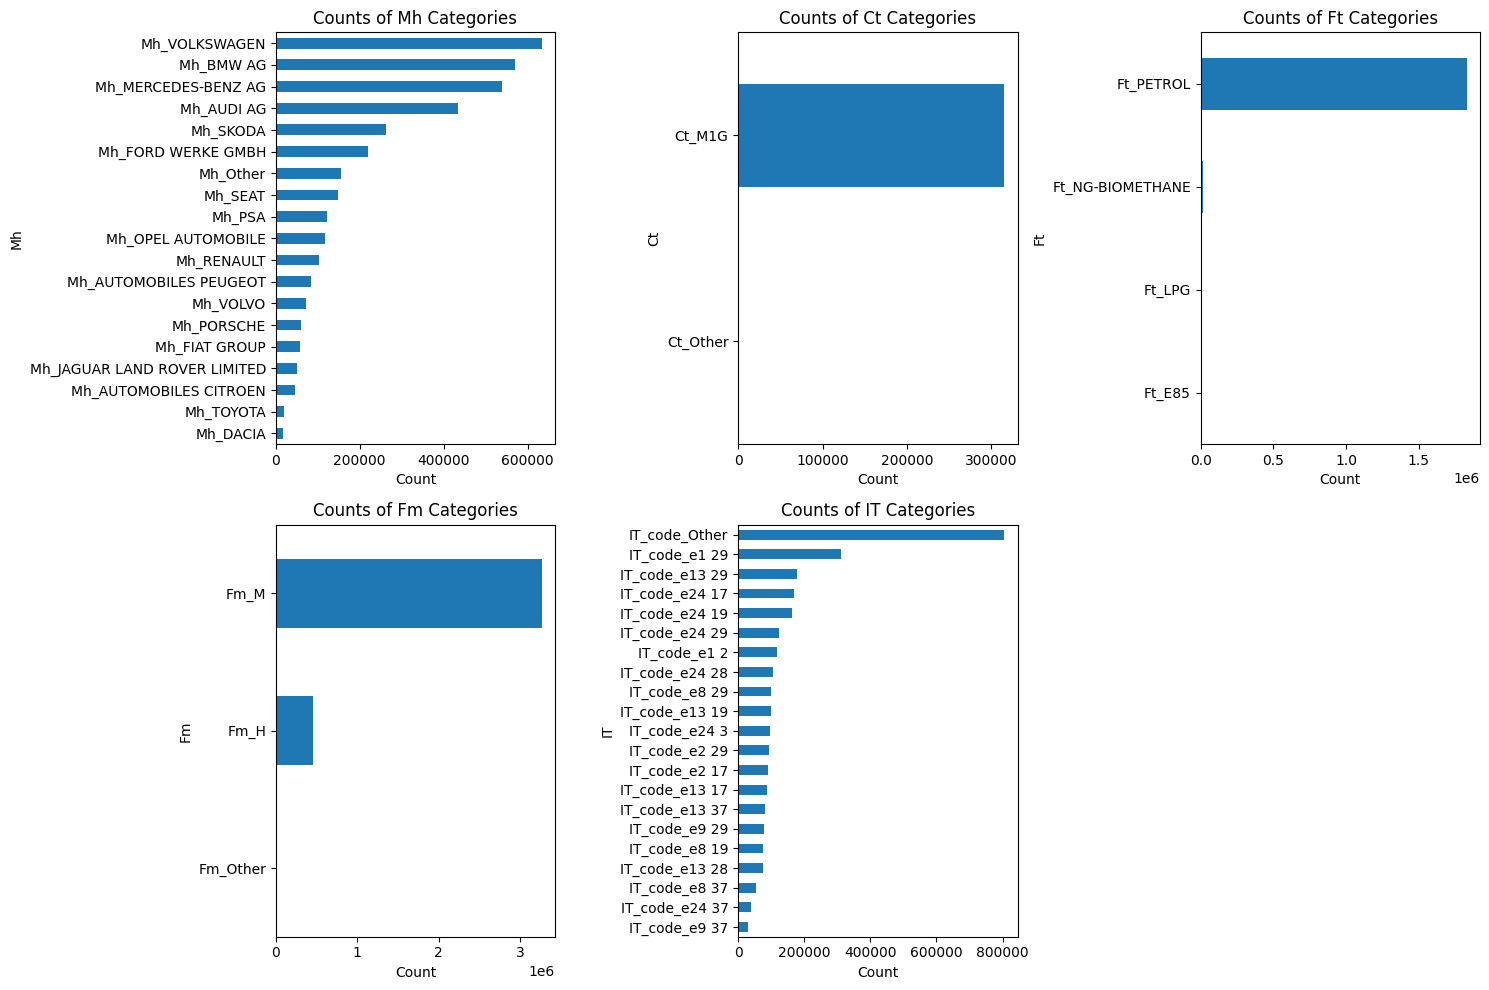

In [ ]:
# function to visualize categorial - vars. of mininmal_X dataset

from collections import defaultdict
import math

def plot_onehot_encoded_barplots_auto(dataset):
    """
    This function takes a dataset with one-hot encoded categorical variables, automatically identifies
    the encoded variables by checking for binary columns, groups them by their prefix, and creates
    horizontal barplots for each original categorical variable represented by one-hot encoding.

    Parameters:
    - dataset: DataFrame with one-hot encoded columns.
    """
    # Detect one-hot encoded columns by finding binary columns with exactly two unique values (0 and 1)
    onehot_encoded_vars = [col for col in dataset.columns if dataset[col].nunique() == 2 and set(dataset[col].unique()) == {0, 1}]

    # Automatically group one-hot encoded variables by their prefixes (assumes prefix before an underscore)
    onehot_groups = defaultdict(list)
    for col in onehot_encoded_vars:
        prefix = col.split('_')[0]  # Assuming prefix is the part before the first underscore
        onehot_groups[prefix].append(col)

    # Plot each one-hot encoded group using subplots
    num_vars = len(onehot_groups)
    cols = 3
    rows = math.ceil(num_vars / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, (var, cols) in enumerate(onehot_groups.items()):
        # Count the occurrences of each category in the original variable
        category_counts = dataset[cols].sum().sort_values()

        # Plot as a horizontal bar chart in the corresponding subplot
        category_counts.plot(kind='barh', ax=axes[i])
        axes[i].set_title(f'Counts of {var} Categories')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(var)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# plot the cat vars of min_dataset
plot_onehot_encoded_barplots_auto(df)


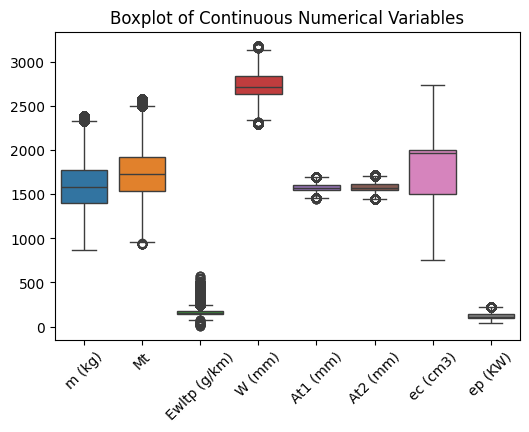

In [ ]:
# function to visualize numerical - vars. of mininmal_X dataset

def plot_numerical_boxplots_exclude_onehot(dataset):
    """
    This function takes a dataset, selects only continuous numerical variables
    (excluding one-hot encoded columns),
    and creates a single boxplot figure for these variables in one plot.
    """
    # Select numerical columns and exclude one-hot encoded (binary) columns
    numerical_vars = dataset.select_dtypes(include=['number']).columns
    continuous_vars = [var for var in numerical_vars if dataset[var].nunique() > 2]

    # Create a single boxplot figure with continuous numerical variables
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=dataset[continuous_vars])
    plt.xticks(rotation=45)
    plt.title("Boxplot of Continuous Numerical Variables")
    plt.show()

plot_numerical_boxplots_exclude_onehot(df)
# took 2min 30sec

In [ ]:
# create micro feature / reduce vars (At1 (mm), At2 (mm), W (mm) -> WA (m2))

# Calculate WA (m2) as the wheel area
df['WA (m2)'] = ((df['At1 (mm)'] + df['At2 (mm)']) / 2 * df['W (mm)']) / 1_000_000


In [ ]:
# Linear regressor
# adapted to work with mini_dataset
#---------------------------------------------------------------------------#

# Simple linear regression model
#  scaling the features (after cat. encoding, which done in min_dataset)
#  with duplicates / wo duplicates

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Drop all duplicate rows, toggle and run the variants
# df = df.drop_duplicates()

# define features to keep, here are all columns listed
all_col = ['m (kg)', 'Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)',
       'ec (cm3)', 'ep (KW)', 'Mh_AUDI AG', 'Mh_AUTOMOBILES CITROEN',
       'Mh_AUTOMOBILES PEUGEOT', 'Mh_BMW AG', 'Mh_DACIA', 'Mh_FIAT GROUP',
       'Mh_FORD WERKE GMBH', 'Mh_JAGUAR LAND ROVER LIMITED',
       'Mh_MERCEDES-BENZ AG', 'Mh_OPEL AUTOMOBILE', 'Mh_PORSCHE', 'Mh_PSA',
       'Mh_RENAULT', 'Mh_SEAT', 'Mh_SKODA', 'Mh_TOYOTA', 'Mh_VOLKSWAGEN',
       'Mh_VOLVO', 'Mh_Other', 'Ct_M1G', 'Ct_Other', 'Ft_E85', 'Ft_LPG',
       'Ft_NG-BIOMETHANE', 'Ft_PETROL', 'Fm_H', 'Fm_M', 'Fm_Other',
       'IT_code_Other', 'IT_code_e1 2', 'IT_code_e1 29', 'IT_code_e13 17',
       'IT_code_e13 19', 'IT_code_e13 28', 'IT_code_e13 29', 'IT_code_e13 37',
       'IT_code_e2 17', 'IT_code_e2 29', 'IT_code_e24 17', 'IT_code_e24 19',
       'IT_code_e24 28', 'IT_code_e24 29', 'IT_code_e24 3', 'IT_code_e24 37',
       'IT_code_e8 19', 'IT_code_e8 29', 'IT_code_e8 37', 'IT_code_e9 29',
       'IT_code_e9 37', 'WA (m2)']

# create target data: var y (pd series)
y = df["Ewltp (g/km)"]
print("Target variable: ", y.name)
print()

# create explanaory data: var X (pd dataframe) in this run
# X = df.drop(["Ewltp (g/km)", "WA (m2)"], axis = 1) # all in
# X = df.drop(["Ewltp (g/km)", "WA (m2)", "m (kg)"], axis = 1) # without m (kg)
X = df.drop(["Ewltp (g/km)", "At1 (mm)", "At2 (mm)", "W (mm)", "m (kg)"], axis = 1)

print("Explanatory variables: \n", X.columns)
print()

# split the data into training, testing sub-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 42)

# align columns in X_train and X_test (in case some categories are not present in test or train)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# create a scaler
scaler = StandardScaler().fit(X_train)

# apply the scaler to X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# display(X_train_scaled)

# create an instance of a lin. reg. modell
lr = LinearRegression()

# train/fit the model
lr.fit(X_train_scaled, y_train)

# display intercept and coeff (slope) together with the var/column involved -> in a df
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)

features = list(X_train.columns)
features.insert(0, "intercept")

coef = pd.DataFrame({"Estimated value": coeffs}, index = features)
# print("Linear regression model coefficients:")
# display(coef)
# print()

# display the score (R²) of the model on the training sample.
score_train = round(lr.score(X_train_scaled, y_train), 3)
print("Score (R²) of the model on the training sample: ", score_train)

# display score of cross validation 5-fold  - mean
score_cross_val = round(cross_val_score(lr, X_train_scaled, y_train, cv = 5).mean(), 3)
print("Score of cross validation - mean: ", score_cross_val)

# display the score (R²) of the model on the test sample.
score_test = round(lr.score(X_test_scaled, y_test), 3)
print("Score (R²) of the model on the test sample: ", score_test)
print()

# store the model pred. for X_train_scaled and X_test_scaled in the
# respective tables (pred_train) and (pred_test).
pred_train = lr.predict(X_train_scaled)
pred_test = lr.predict(X_test_scaled)

# display the roots of the mean square errors RMSE for both samples.
rmse_train = round(np.sqrt(mean_squared_error(y_train, pred_train)),2)
rmse_test =  round(np.sqrt(mean_squared_error(y_test, pred_test)),2)
print("RMSE on train-set: ", rmse_train)
print("RMSE on test-set: ", rmse_test)
print()

#-------------------------------------------------
# concatenate X_train, y_train
# df_train = pd.concat([X_train, y_train], axis = 1)

# calc correlation
# df_train_cor = round(df_train.corr(),2)

# display heatmap
# plt.figure(figsize=(22,18))
# sns.heatmap(df_train_cor, annot = False);
# -------------------------------------------------

# All in:
# with duplicates
# Score (R²) of the model on the training sample:  0.809
# Score of cross validation - mean:  0.809
# Score (R²) of the model on the test sample:  0.81
# RMSE on train-set:  15.14
# RMSE on test-set:  15.1

# Without m (kg) [running order mass]:
# with duplicates
# Score (R²) of the model on the training sample:  0.786
# Score of cross validation - mean:  0.786
# Score (R²) of the model on the test sample:  0.787
# RMSE on train-set:  16.01
# RMSE on test-set:  15.97

# Without m (kg) [running order mass], At1, At2, W,  instead WA (m2):
# with duplicates
# Score (R²) of the model on the training sample:  0.781
# Score of cross validation - mean:  0.781
# Score (R²) of the model on the test sample:  0.782
# RMSE on train-set:  16.2
# RMSE on test-set:  16.16

# ----

# All in:
# withOut duplicates
# Score (R²) of the model on the training sample:  0.854
# Score of cross validation - mean:  0.854
# Score (R²) of the model on the test sample:  0.854
# RMSE on train-set:  12.57
# RMSE on test-set:  12.55

# Without m (kg) [running order mass]:
# withOut duplicates
# Score (R²) of the model on the training sample:  0.846
# Score of cross validation - mean:  0.846
# Score (R²) of the model on the test sample:  0.847
# RMSE on train-set:  12.88
# RMSE on test-set:  12.87

# Without m (kg) [running order mass], At1, At2, W,  instead WA (m2):
# withOut duplicates
# Score (R²) of the model on the training sample:  0.844
# Score of cross validation - mean:  0.844
# Score (R²) of the model on the test sample:  0.844
# RMSE on train-set:  12.98
# RMSE on test-set:  12.96

# Results: Slightly better results with droping the duplicates
# RMSE 15.1  -> 12.6 in the all-in version

Target variable:  Ewltp (g/km)

Explanatory variables: 
 Index(['Mt', 'ec (cm3)', 'ep (KW)', 'Mh_AUDI AG', 'Mh_AUTOMOBILES CITROEN',
       'Mh_AUTOMOBILES PEUGEOT', 'Mh_BMW AG', 'Mh_DACIA', 'Mh_FIAT GROUP',
       'Mh_FORD WERKE GMBH', 'Mh_JAGUAR LAND ROVER LIMITED',
       'Mh_MERCEDES-BENZ AG', 'Mh_OPEL AUTOMOBILE', 'Mh_PORSCHE', 'Mh_PSA',
       'Mh_RENAULT', 'Mh_SEAT', 'Mh_SKODA', 'Mh_TOYOTA', 'Mh_VOLKSWAGEN',
       'Mh_VOLVO', 'Mh_Other', 'Ct_M1G', 'Ct_Other', 'Ft_E85', 'Ft_LPG',
       'Ft_NG-BIOMETHANE', 'Ft_PETROL', 'Fm_H', 'Fm_M', 'Fm_Other',
       'IT_code_Other', 'IT_code_e1 2', 'IT_code_e1 29', 'IT_code_e13 17',
       'IT_code_e13 19', 'IT_code_e13 28', 'IT_code_e13 29', 'IT_code_e13 37',
       'IT_code_e2 17', 'IT_code_e2 29', 'IT_code_e24 17', 'IT_code_e24 19',
       'IT_code_e24 28', 'IT_code_e24 29', 'IT_code_e24 3', 'IT_code_e24 37',
       'IT_code_e8 19', 'IT_code_e8 29', 'IT_code_e8 37', 'IT_code_e9 29',
       'IT_code_e9 37', 'WA (m2)'],
      dtype='object'

In [ ]:
# Regression with XG-Boost
#
# scaleing is not neccesary in XG-Boost

# import xgboost-model
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

# Drop all duplicate rows, toggle and run the variants
df = df.drop_duplicates()

# create target data: var y (pd series)
target = df["Ewltp (g/km)"]
print("Target variable: ", y.name)
print()

# create explanaory data: var X (pd dataframe) in this run without WA (m2
features = df.drop(["Ewltp (g/km)", "WA (m2)"], axis = 1) # all in
# features = df.drop(["Ewltp (g/km)", "WA (m2)", "m (kg)"], axis = 1) # without m (kg)
# features = df.drop(["Ewltp (g/km)", "At1 (mm)", "At2 (mm)", "W (mm)", "m (kg)"], axis = 1)
print("Features: \n", features.columns)
print()

# create a validation set representing 10% of the data
X, X_valid, y, y_valid = train_test_split(features, target, test_size = 0.1, random_state = 42)

# create a training set containing 80% of the remaining data, test set = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#scale the training, validation and test_data (omitted)
# XGBoost does not require scaling of the features because it’s based on
# decision trees, which are not sensitive to the feature scales (to be done...)

# Create a DMAtrix object called train from X_train and y_train.
train = xgb.DMatrix(data = X_train, label = y_train)

# Create a DMAtrix object called test from X_test and y_test.
test = xgb.DMatrix(data = X_test, label = y_test)

# Create a DMAtrix object called valid from X_valid and y_valid
# to monitor the training process and prevent overfitting
valid = xgb.DMatrix(data = X_valid, label = y_valid)

params = {
    'objective': 'reg:squarederror',  # For regression problems, use 'binary:logistic' for binary classification
    'eval_metric': 'rmse',            # Evaluation metric (can be 'rmse', 'mae', or others for regression)
    'learning_rate': 0.2,             # Learning rate (eta)
    'max_depth': 6,                   # Maximum depth of a tree
    'subsample': 0.8,                 # Fraction of the training data to use for growing trees
    'colsample_bytree': 0.8,          # Fraction of features used per tree
    'seed': 42                        # Random seed for reproducibility
}

#-----------------------------------------------------
# 5-fold cross-validation (to determine parameters to then train the model with this parameters)
# cv_results = xgb.cv(params= params, dtrain= train, num_boost_round= 1000, nfold=5, metrics='rmse', early_stopping_rounds=10)

# print best_num_boost_round, early stopping rounds having triggered
# did not trigger, even with 1000 -> 300 are enough
# best_num_boost_round = cv_results.shape[0]
# print("Optimal number of boosting rounds: ", best_num_boost_round)

# print results
# print(cv_results)
#--------------------------------------------------------

# define a watchlist during training (here the separated validation set is used)
watchlist = [(train, 'train'), (valid, 'eval')]

# train the model
model = xgb.train(
    params= params,            # The parameters defined above
    dtrain= train,             # The training DMatrix
    num_boost_round= 30,      # Number of boosting rounds (iterartions)
    evals= watchlist,          # Watchlist to monitor training and validation performance
    early_stopping_rounds= 10  # Early stopping to prevent overfitting
    )

# calc predictions
y_pred_train = model.predict(train)
y_pred_test = model.predict(test)
y_pred_valid = model.predict(valid)

# calculate RMSE on the train set
rmse_train = round(root_mean_squared_error(y_train, y_pred_train),2)
print("Train RMSE: ", rmse_train)

# calculate RMSE on the test set
rmse_test = round(root_mean_squared_error(y_test, y_pred_test),2)
print("Test  RMSE: ", rmse_test)

# calculate RMSE on the validation set
rmse_valid = round(root_mean_squared_error(y_valid, y_pred_valid),2)
print("Valid RMSE: ", rmse_valid)
print()

# calculate R² score
r2_train = round(r2_score(y_train, y_pred_train),3)
r2_test = round(r2_score(y_test, y_pred_test),3)
r2_valid = round(r2_score(y_valid, y_pred_valid),3)

# print R² results
print("Train R²: ", r2_train)
print("Test  R²: ", r2_test)
print("Validation R²: ", r2_valid)

# 300 boosting-rounds
# All in:
# with duplicates
# Train RMSE:  4.47
# Test  RMSE:  4.50
# Valid RMSE:  4.52
# Train R²:  0.983
# Test  R²:  0.983
# Validation R²:  0.983
# took 3min 36sec to complete @ g-colab

# 300 boosting-rounds
# Without m (kg) [running order mass], At1, At2, W,  instead WA (m2):
# with duplicates
# Train RMSE:  5.69
# Test  RMSE:  5.72
# Valid RMSE:  5.69
# Train R²:  0.973
# Test  R²:  0.973
# Validation R²:  0.973
# took 5min 36sec to complete @ g-colab

#--

# 300 boosting-rounds
# All in:
# withOut duplicates
# Train RMSE:  4.69
# Test  RMSE:  4.85
# Valid RMSE:  4.87
# Train R²:  0.980
# Test  R²:  0.978
# Validation R²:  0.978
# takes 2min 46sec to complete @ g-colab

# 300 boosting-rounds
# Without m (kg) [running order mass], At1, At2, W,  instead WA (m2):
# withOut duplicates
# Train RMSE:  5.9
# Test  RMSE:  6.01
# Valid RMSE:  6.04
# Train R²:  0.968
# Test  R²:  0.967
# Validation R²:  0.966
# took 3min 9sec to complete @ g-colab

# 1500 boosting-rounds
# Without m (kg) [running order mass], At1, At2, W,  instead WA (m2):
# withOut duplicates
# Train RMSE:  4.96
# Test  RMSE:  5.21
# Valid RMSE:  5.26
# Train R²:  0.977
# Test  R²:  0.975
# Validation R²:  0.974
# took 10min 35sec to complete @ g-colab


# Results:
# A bit better with duplicates and "all-in"
# Model can be tweaked for better performance with more
# rounds, but it takes for me "too much" time
# R² 4.5 <-> 4.8

Target variable:  Ewltp (g/km)

Features: 
 Index(['m (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)',
       'Mh_AUDI AG', 'Mh_AUTOMOBILES CITROEN', 'Mh_AUTOMOBILES PEUGEOT',
       'Mh_BMW AG', 'Mh_DACIA', 'Mh_FIAT GROUP', 'Mh_FORD WERKE GMBH',
       'Mh_JAGUAR LAND ROVER LIMITED', 'Mh_MERCEDES-BENZ AG',
       'Mh_OPEL AUTOMOBILE', 'Mh_PORSCHE', 'Mh_PSA', 'Mh_RENAULT', 'Mh_SEAT',
       'Mh_SKODA', 'Mh_TOYOTA', 'Mh_VOLKSWAGEN', 'Mh_VOLVO', 'Mh_Other',
       'Ct_M1G', 'Ct_Other', 'Ft_E85', 'Ft_LPG', 'Ft_NG-BIOMETHANE',
       'Ft_PETROL', 'Fm_H', 'Fm_M', 'Fm_Other', 'IT_code_Other',
       'IT_code_e1 2', 'IT_code_e1 29', 'IT_code_e13 17', 'IT_code_e13 19',
       'IT_code_e13 28', 'IT_code_e13 29', 'IT_code_e13 37', 'IT_code_e2 17',
       'IT_code_e2 29', 'IT_code_e24 17', 'IT_code_e24 19', 'IT_code_e24 28',
       'IT_code_e24 29', 'IT_code_e24 3', 'IT_code_e24 37', 'IT_code_e8 19',
       'IT_code_e8 29', 'IT_code_e8 37', 'IT_code_e9 29', 'IT_code_e9 37'],


<ipython-input-18-6c02c3f9a627>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f"{int(tick):,}" for tick in ax1.get_xticks()])


<Figure size 640x480 with 0 Axes>

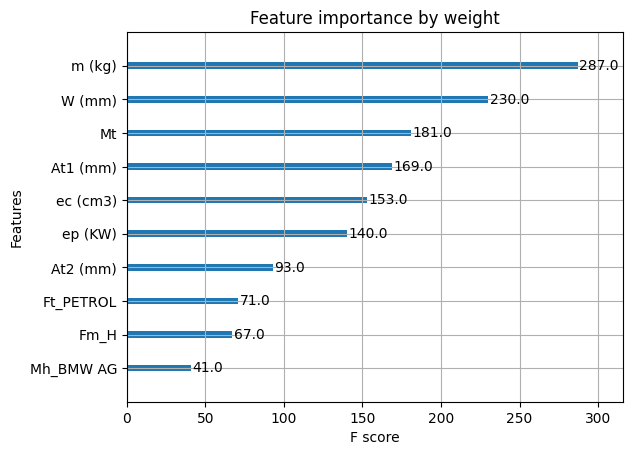

<ipython-input-18-6c02c3f9a627>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f"{float(tick):.2f}" for tick in ax2.get_xticks()])


<Figure size 640x480 with 0 Axes>

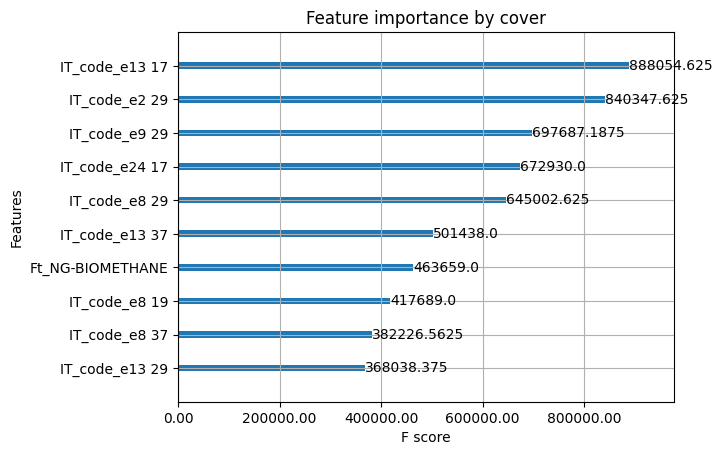

<ipython-input-18-6c02c3f9a627>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([f"{float(tick):.2f}" for tick in ax3.get_xticks()])


<Figure size 640x480 with 0 Axes>

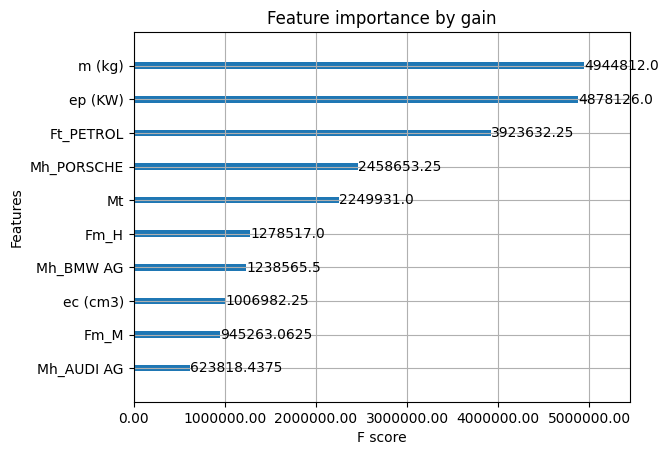

In [ ]:
# ? Interpretation -> which features are the most important... explain : )
#
# # Print feature importance using different importance types
# print("Feature importance (by weight):")
# print(model.get_score(importance_type='weight'))  # Number of times a feature is used in trees

# print("Feature importance (by cover):")
# print(model.get_score(importance_type='cover'))  # Coverage (number of samples affected by splits)

# print("Feature importance (by gain):")
# print(model.get_score(importance_type='gain'))  # Gain (average improvement made by a feature)

# Plot feature importance by weight
plt.figure()
ax1 = xgb.plot_importance(model, importance_type='weight', max_num_features=10)  # Plot top 10 features
ax1.set_xticklabels([f"{int(tick):,}" for tick in ax1.get_xticks()])
plt.title("Feature importance by weight")
plt.show();

# plot feature importance by cover
plt.figure()
ax2 = xgb.plot_importance(model, importance_type='cover', max_num_features=10)  # Plot top 10 features
ax2.set_xticklabels([f"{float(tick):.2f}" for tick in ax2.get_xticks()])
plt.title("Feature importance by cover")
plt.show();

# plot feature importance by gain
plt.figure();
ax3 = xgb.plot_importance(model, importance_type='gain', max_num_features=10)  # Plot top 10 features
ax3.set_xticklabels([f"{float(tick):.2f}" for tick in ax3.get_xticks()])
plt.title("Feature importance by gain")
plt.show()

,Ewltp (g/km)
count,2.130440e+06
mean,1.626204e+02
std,3.281246e+01
min,1.100000e+01
25%,1.390000e+02
50%,1.550000e+02
75%,1.800000e+02
max,5.720000e+02


<Axes: xlabel='Ewltp (g/km)', ylabel='Count'>

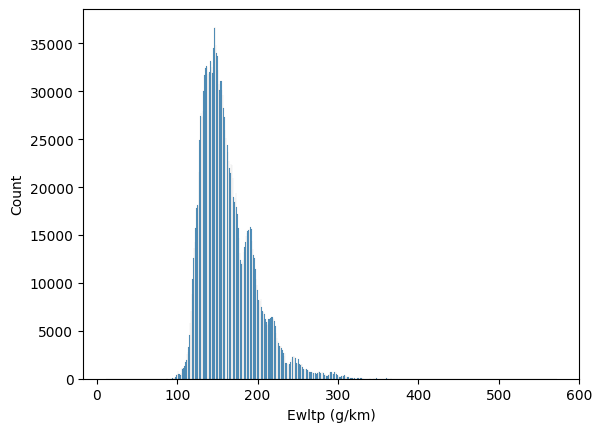

In [ ]:
# Classification multiclas with XG-Boost (try)
display(df["Ewltp (g/km)"].describe())

# histogram of Ewltp
sns.histplot(df["Ewltp (g/km)"])


In [ ]:
# Set options to display all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


# value counts of Ewltp
display(df["Ewltp (g/km)"].value_counts().sort_index(ascending = False))

,m (kg),Mt,Ewltp (g/km),W (mm),At1 (mm),At2 (mm),ec (cm3),ep (KW),Mh_AUDI AG,Mh_AUTOMOBILES CITROEN,...,IT_code_e24 28,IT_code_e24 29,IT_code_e24 3,IT_code_e24 37,IT_code_e8 19,IT_code_e8 29,IT_code_e8 37,IT_code_e9 29,IT_code_e9 37,WA (m2)
5525899,1008.0,1104.0,18.0,2385.0,1455.0,1468.0,998.0,49.0,0,0,...,0,0,0,0,0,0,0,0,0,3.485677
4692767,1035.0,1134.0,52.0,2300.0,1569.0,1575.0,1242.0,51.0,0,0,...,0,0,0,0,0,0,0,0,0,3.615600
5434192,935.0,1020.0,13.0,2710.0,1471.0,1575.0,999.0,52.0,0,0,...,0,0,0,0,0,0,0,0,0,4.127330
6122692,915.0,1006.0,14.0,2340.0,1569.0,1575.0,998.0,53.0,0,1,...,0,0,0,0,0,0,0,0,0,3.678480
9887163,1165.0,1314.0,73.0,2560.0,1520.0,1520.0,1490.0,68.0,0,0,...,0,0,0,0,0,0,0,0,0,3.891200
8204202,1160.0,1275.0,64.0,2560.0,1530.0,1530.0,1490.0,68.0,0,0,...,0,0,0,0,0,0,0,0,0,3.916800
8204195,1165.0,1297.0,73.0,2560.0,1520.0,1520.0,1490.0,68.0,0,0,...,0,0,0,0,0,0,0,0,0,3.891200
8452271,1985.0,2117.0,38.0,2670.0,1545.0,1545.0,2360.0,72.0,0,0,...,0,0,0,0,0,0,0,0,0,4.125150
4695675,1349.0,1445.0,15.0,2519.0,1519.0,1517.0,998.0,92.0,0,0,...,0,0,0,0,0,0,0,0,0,3.823842
5239185,1473.0,1590.0,15.0,2648.0,1559.0,1569.0,999.0,92.0,0,0,...,0,0,0,0,0,0,0,0,0,4.141472


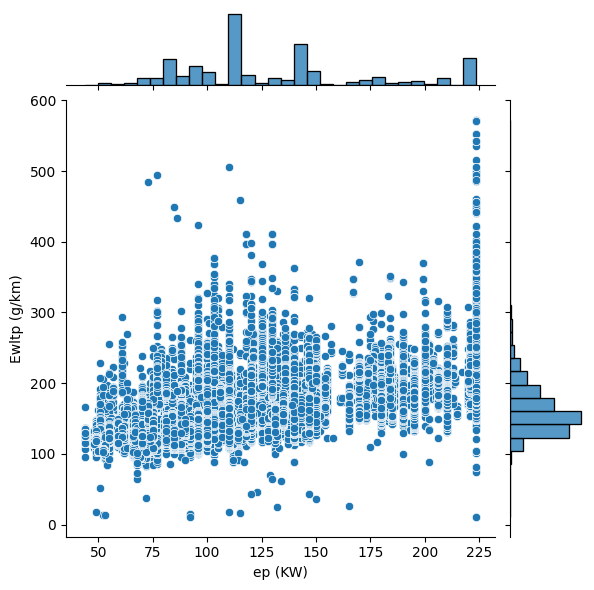

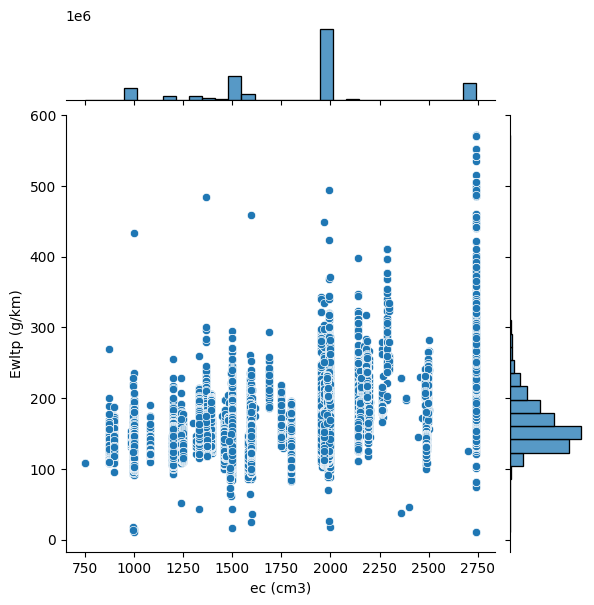

In [ ]:
display(df.loc[df["Ewltp (g/km)"] <= 80].sort_values(by="ep (KW)"))

# scatterplot + hist of ep (KW) versus Ewltp (g/km)
sns.jointplot(x= df["ep (KW)"], y= df["Ewltp (g/km)"], data=df, kind="scatter", marginal_kws=dict(bins=30, fill=True))
plt.show();

# scatterplot + hist of ec (cm3) versus Ewltp (g/km)
sns.jointplot(x= df["ec (cm3)"], y= df["Ewltp (g/km)"], data=df, kind="scatter", marginal_kws=dict(bins=30, fill=True))
plt.show();

In [ ]:
# Classifier XGBoost

# import xgboost-model
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# define bin parameters for target var to be binned
bin_size = 5
min_value = 11
max_value = 572

# Create bins and labels for the Ewltp target variable
bins = np.arange(min_value, max_value + bin_size, bin_size)
labels = np.arange(len(bins) - 1)

# Convert the continuous Ewltp target variable into discrete classes
df['Ewltp_binned'] = pd.cut(df['Ewltp (g/km)'], bins=bins, labels=labels, right=False).astype(int)

# Prepare features (X) and the binned target (y)
features = df.drop(columns=['Ewltp (g/km)', 'Ewltp_binned', 'WA (m2)'])
target = df['Ewltp_binned']

# create a validation set representing 10% of the data
X, X_valid, y, y_valid = train_test_split(features, target, test_size = 0.1, random_state = 42)

# create a training set containing 80% of the remaining data, test set = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#scale the training, validation and test_data (omitted)
# XGBoost does not require scaling of the features because it’s based on
# decision trees, which are not sensitive to the feature scales (to be done...)

# Create a DMAtrix object called train from X_train and y_train.
train = xgb.DMatrix(data = X_train, label = y_train)

# Create a DMAtrix object called test from X_test and y_test.
test = xgb.DMatrix(data = X_test, label = y_test)

# Create a DMAtrix object called valid from X_valid and y_valid
# to monitor the training process and prevent overfitting
valid = xgb.DMatrix(data = X_valid, label = y_valid)

# Define parameters for multiclass classification
num_classes = len(labels)            # The number of bins created
params = {
    'objective': 'multi:softmax',    # Set for multiclass classification
    'eval_metric': 'mlogloss',       # Evaluation metric for multiclass classification
    'learning_rate': 0.2,            # Learning rate (eta)
    'max_depth': 6,                  # Maximum depth of a tree
    'subsample': 0.8,                # Fraction of the training data to use for growing trees
    'colsample_bytree': 0.8,         # Fraction of features used per tree
    'seed': 42,                      # Random seed for reproducibility
    'num_class': num_classes         # Set to the number of unique classes/bins
}

# Create the watchlist for monitoring
watchlist = [(train, 'train'), (valid, 'valid')]

# Train the model using XGBoost for multiclass classification
model = xgb.train(
    params=params,                  # The parameters defined above
    dtrain=train,                   # The training DMatrix
    num_boost_round= 120,           # Number of boosting rounds (iterations)
    evals=watchlist,                # Watchlist to monitor training and validation performance
    early_stopping_rounds= 10       # Early stopping to prevent overfitting
)


# calc predictions
y_pred_train = model.predict(train)
y_pred_test = model.predict(test)
y_pred_valid = model.predict(valid)

# Evaluate on the training set
#   Used for learning the model parameters
#   Useful to detect overfitting. If your model performs significantly better on
#   the training set than on validation or test sets, it’s likely overfitting.
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='weighted')
train_recall = recall_score(y_train, y_pred_train, average='weighted')
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

print("Training Accuracy: ", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:   ", train_recall)
print("Training F1 Score: ", train_f1)
print()

# Evaluate on the validation set
#  Used for tuning hyperparam. and monitoring model performance during training
#  Always compute these metrics after each tuning step (e.g., adjusting param.,
#  adding features) to verify that changes improve perfor. without overfitting
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_precision = precision_score(y_valid, y_pred_valid, average='weighted')
valid_recall = recall_score(y_valid, y_pred_valid, average='weighted')
valid_f1 = f1_score(y_valid, y_pred_valid, average='weighted')

print("Validation Accuracy: ", valid_accuracy)
print("Validation Precision:", valid_precision)
print("Validation Recall:   ", valid_recall)
print("Validation F1 Score: ", valid_f1)
print()

# Evaluate on the test set
#  Used for final evaluation of the model after training and tuning are complete
#  Use only once the model is finalized, and avoid repeated evaluations on the
#  test set to prevent overfitting to this specific data.
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Test Accuracy: ", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:   ", test_recall)
print("Test F1 Score: ", test_f1)
print()

# print the classification report for y_test / y_pred_test
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))




# Convert class labels back to continuous values (optional, using bin midpoints)
# bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Convert predicted class labels from the training set back to continuous values (optional)
# y_pred_continuous_train = bin_midpoints[y_pred_train.astype(int)]

# Convert predicted class labels from the validation set back to continuous values (optional)
# y_pred_continuous_valid = bin_midpoints[y_pred_valid.astype(int)]

# Convert predicted class labels from the test set back to continuous values (optional)
# y_pred_continuous_test = bin_midpoints[y_pred_test.astype(int)]


# Run 1: (all-in with duplicates)
# took 11.11 / 12.67 GB of RAM @ clean-start !    > almost limit <
# took 20Min 32sec for > 20 <  rounds  : /
#
# Training Accuracy:  0.476
# Training Precision: 0.478
# Training Recall:    0.476
# Training F1 Score:  0.475

# Validation Accuracy:  0.474
# Validation Precision: 0.476
# Validation Recall:    0.474
# Validation F1 Score:  0.473

# Test Accuracy:  0.474
# Test Precision: 0.476
# Test Recall:    0.473
# Test F1 Score:  0.472


# Run 2: (all-in with duplicates)
# took 11.29 / 12.67 GB of RAM @ clean-start !    > almost limit <
# took 120Min for  > 120 < rounds

# Training Accuracy:  0.625
# Training Precision: 0.625
# Training Recall:    0.625
# Training F1 Score:  0.625

# Validation Accuracy:  0.621
# Validation Precision: 0.620
# Validation Recall:    0.621
# Validation F1 Score:  0.620

# Test Accuracy:  0.621
# Test Precision: 0.621
# Test Recall:    0.621
# Test F1 Score:  0.621
